In [1]:
%matplotlib inline

# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# Traduit et décomposé par Camille Besse
# License: BSD 3 clause
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#pylab.rcParams.keys()
fg = (24,8)
cm_points = ListedColormap(['#FF0000','#FFFFFF', '#00FF00','#000000', '#0000FF'])
cm = 'jet_r'
params = {'figure.titlesize': 'xx-large',
          'font.size': '12',
          'text.color': 'k',
          'figure.figsize': fg,
         }
pylab.rcParams.update(params)



Automatically created module for IPython interactive environment


---
# Comparaison des Algorithmes de Classification
---

Une comparaison va être proposée entre plusieurs classificateurs de la librairie Python SciKit-Learn sur des ensembels de données synthétiques. Le but de cet exercice est d'illustrer la nature des frontières de décision des différents algorithems de classification. Faites attention cependant, les intuitions qui se dégagent de ces exemples pourraient ne pas se transferer sur des ensembles de données rééls.

En particulier avec des données de grande dimensionnalité, celles-ci peuvent être facilement séparées linérairement, et des algorithmes simples comme le Naive Bayes ou les SVMs linéaires peuvent donner de meilleurs résultats en terme de généralisation que ce que donneraient des algorthmes plus complexes ou avec plus de capacité. 

Les fonctions pour permettre l'affichage vont présenter les données d'entrainement comme des points solides annotés de leur couleur. Les points de tests seront semi-transparents avec leur couleur "vraie". La valeur en bas à droite donne la précision de l'algorithme sur l'ensemble de données de test.

source traduite : http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

<!-- Source : 
A comparison of a several classifiers in scikit-learn on synthetic datasets. The point of this example is to illustrate the nature of decision boundaries of different classifiers. This should be taken with a grain of salt, as the intuition conveyed by these examples does not necessarily carry over to real datasets. 

Particularly in high-dimensional spaces, data can more easily be separated linearly and the simplicity of classifiers such as naive Bayes and linear SVMs might lead to better generalization than is achieved by other classifiers.

The plots show training points in solid colors and testing points semi-transparent. The lower right shows the classification accuracy on the test set. -->



---
## Ensembles de données
---

Les trois ensembles de données que nous allons utiliser sont les suivants : 
- Les lunes
- les cercles 
- un ensemble linéairement séparable

Nous pouvons mettre différent niveaux de bruits dans ces données. Voyons ce que ca donne.

In [2]:
# Paramètres initiaux des données : 
## Pour le générateur de nombre pseu-aléatoires et la reproductibilité des résultats
rng_seed = 0 
## Le bruit dans les données (entre 0 et 0.5)
bruit = 0.
# ---

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=rng_seed, n_clusters_per_class=2, flip_y=bruit/10,class_sep=2-2*bruit)
rng = np.random.RandomState(rng_seed)
X += bruit * 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

names = ["Lunes", "Cercles", "Séparables"]
datasets = [make_moons(noise=bruit, random_state=rng_seed),
            make_circles(noise=bruit/2, factor=0.5, random_state=rng_seed),
            linearly_separable
            ]

Affichons maintenant ces datasets:

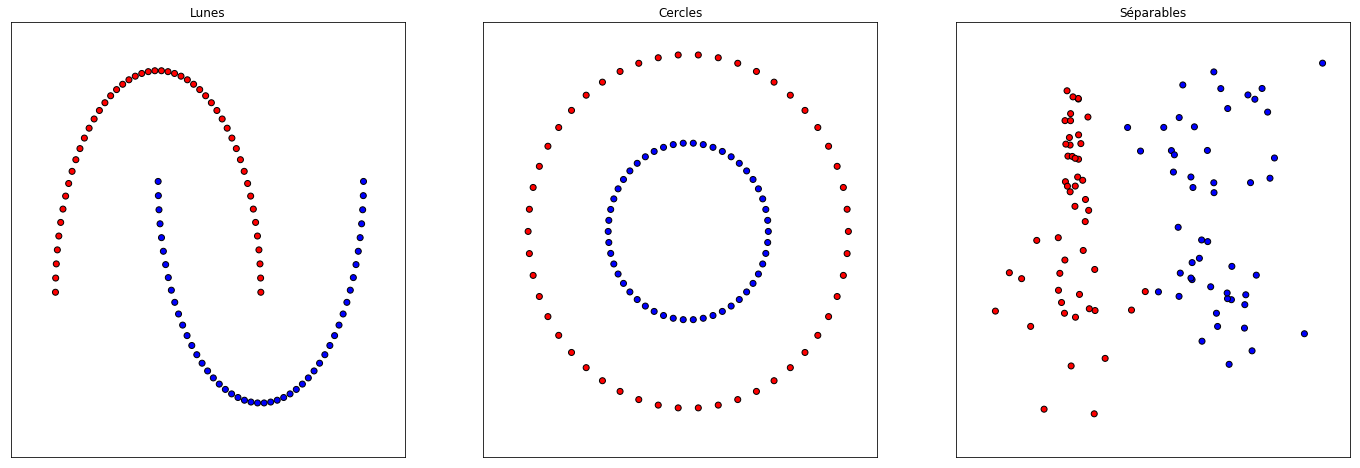

In [3]:
# Création des graphiques
figure = plt.figure(figsize=fg)
i = 1

# Pour chaque dataset (compteur, DataSet)
for ds_cnt, ds in enumerate(datasets):
    # Préparation rapide des données : normalisation des données et calcul des bornes 
    X, y = ds
    h = 0.2
    X = StandardScaler().fit_transform(X)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Visualisons le data set 
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(1, len(datasets), i)
    
    ax.set_title(names[ds_cnt])
        
    # Affichons les ensembles de données
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_points, edgecolors='k')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    ## EXERCICE : Jouez avec les paramètres de bruit initiaux pour voir les différences dans les données

Définissons un ensemble de fonctions qui vont nous aider à visualiser plus ismplement les résultats des différents classificateurs:

In [4]:
def creationMesh(X):
    """
    Crée un grille sur un espace bidimensionnel. Prends le min et le max de chaque dimension et calcule la grille avec une résolution de 0.02. 
    X: un vecteur à deux colonnes de données. 
    """
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx,yy


def plotClassifierOnData(name,clf,data,i=3,n=1,multi=False):
    """
    Pour Afficher les récultat d'un classificateur sur un dataset
    name : le titre du graphique
    clf : le classificateur à utiliser
    data : les données à utiliser
    i : Le ième graphique sur n à afficher (pour afficher 3 graphiques par ligne)
    n : Le nombre total de graphiques à afficher
    multi: détermine si on affiche juste la frontière de décision (true) ou 
           le score/proba de chaque point de l'espace car on ne peut afficher le score en multiclasse.
    """
    
    # Préparation rapide des données : 
    # normalisation des données 
    X, y = data
    X = StandardScaler().fit_transform(X)
    # Séparation des données en TRAIN - TEST
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=rng_seed)
    # Pour la visualisation des régions et calcul des bornes 
    xx,yy = creationMesh(X)

    # creation du bon nombre de figures à afficher (3 par lignes)
    ax = plt.subplot(n/3,3,i)
    
    # entrainement du classificateur et calcul du score final (accuracy)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Pour afficher les frontières de décision on va choisir une color pour 
    # chacun des points x,y du mesh [x_min, x_max]x[y_min, y_max].

    # Si on est en multiclasse (2 ou +) on affiche juste les frontières
    if multi:
         Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    else:# sinon on peut afficher le gradient du score
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # On affiche le mesh de décision
    Z = Z.reshape(xx.shape)
    test = ax.contourf(xx, yy, Z, 100, cmap=cm, alpha=.8)

    #On affiche la légende
    cbar = plt.colorbar(test)
    cbar.ax.set_title('score')
    
    # On affiche les points d'entrainement
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_points,
               edgecolors='k',s=100)
    # Et les points de test
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_points, 
               edgecolors='k',marker='X',s=100)

    # on définit les limites des axes et autres gogosses
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
#     ax.set_xticks(())
#     ax.set_yticks(())
    ax.set_title(name,fontsize=22)
    # dont le score en bas à droite
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')


def plotClassifier(name, clf, datasets):
    """
    Affiche pour un classificateur donné, son résultat sur l'ensemble des datasets préalablement déterminés
    name : le nom du classificateur à afficher (titre du graphique)
    clf : un classificateur de scikit-learn
    datasets : une liste de datasets
    """
    f = plt.figure(figsize=fg)
    # Pour chacun des DataSet
    for ds_cnt, ds in enumerate(datasets):
        plotClassifierOnData(name, clf, ds,ds_cnt+1,3)

    plt.tight_layout()
    plt.show()

---
## Algorithmes de Classification
---

Voyons maintenant les différents algorithmes et leur(s) paramètre(s):
1. <a href="#knn">KNN</a>
2. <a href="#cart">Arbre de décision</a>
3. <a href="#rf">Random Forest</a>
4. <a href="#ada">AdaBoost</a>
5. <a href="#boost">Gradient Boosting</a>
6. <a href="#rl">Régression logistique</a>
7. <a href="#nn">Réseaux de neurones</a>
8. <a href="#svm">SVM(s)</a>
9. <a href="#gp">Processus Gaussiens</a> 


<div id="knn"/>
## 1. K-Nearest Neighbors (KNN) 

Ou les K plus proches voisins. 

[`sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Les principaux paramètres de la classe `sklearn.neighbors.KNeighborsClassifier` sont:
- `n_neighbors` : le nombre de voisins considérés
- `weights` : `uniform` (tous les poids sont égaux), `distance` (le poids est inversement proportionnel à la distance par rapport à l'échantillon testé) ou toute autre fonction lambda définie par l'utilisateur;
- `algorithm` : `brute`, `ball_tree`, `KD_tree` ou `auto`. Dans le premier cas, les voisins les plus proches pour chaque cas de test sont calculés par une recherche sur la grille sur l'ensemble d'apprentissage. Dans les deuxième et troisième cas, les distances entre les exemples sont stockées dans un arbre pour accélérer la recherche des voisins les plus proches. Si vous définissez ce paramètre sur auto, la bonne façon de trouver les voisins sera automatiquement choisie en fonction du jeu d’entraînement.
- `leaf_size` : seuil pour passer à la recherche sur la grille si l'algorithme de recherche de voisins est `ball_tree` ou `KD_tree`;
- `metric` : fonction de calcul de la distance netre les points : `minkowski` (par défaut), `manhattan` (si `p`= 1), `euclidean` (si `p`= 2), `chebyshev` (si `p`= Infini).

**Note :** souffre de la malédiction de la dimensionnalité. Pour des datasets de plusieurs millions de données dans de grandes dimensions, cf. [Annoy](https://github.com/spotify/annoy) la librairie de Spotify sur les K-NN approximés.

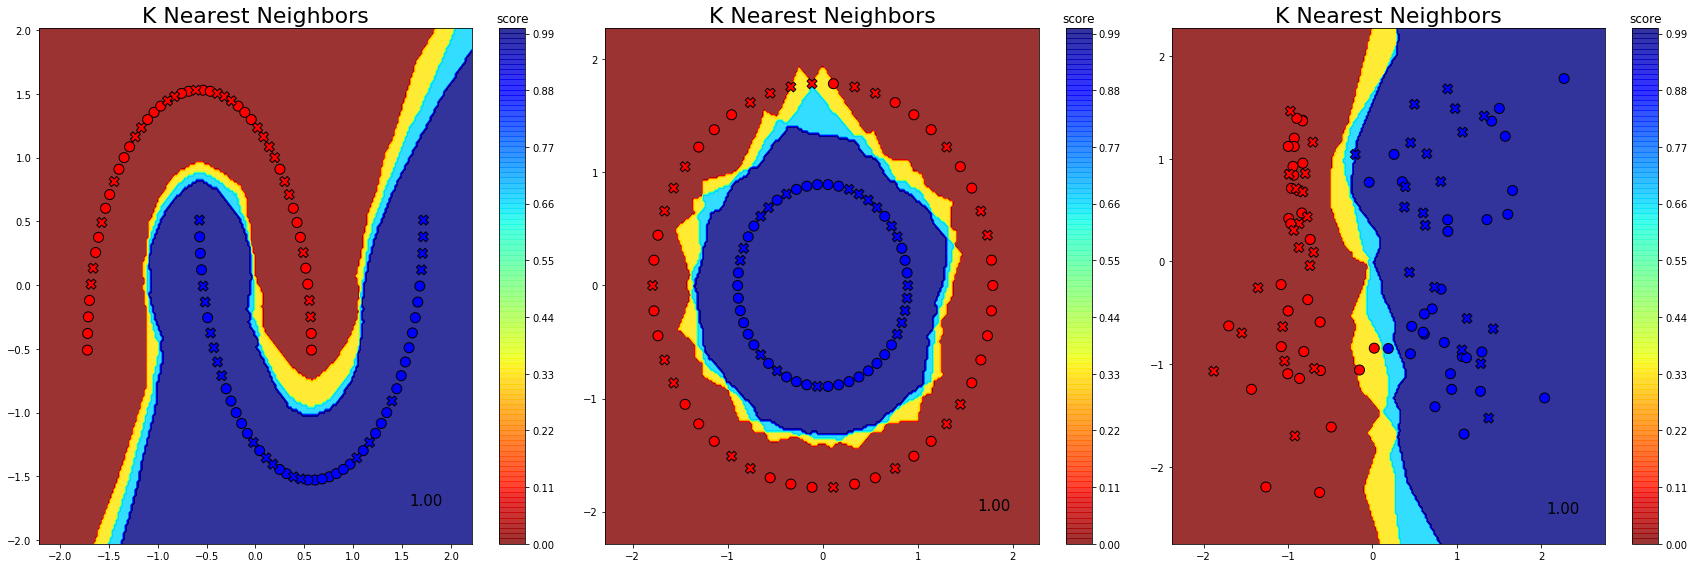

In [5]:
K = 3
w = 'uniform' #ou 'distance'

plotClassifier("K Nearest Neighbors", KNeighborsClassifier(n_neighbors=K, weights=w, algorithm='auto', leaf_size=30, metric='minkowski', p=2), datasets)

<div id="cart"/>
## 2. Arbres de Decision

[`sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Les principaux paramètres de la classe sklearn.tree.DecisionTreeClassifier sont les suivants:
- `max_depth` : la profondeur maximale de l'arbre;
- `max_features` : nombre maximal de caractéristiques permettant de rechercher la meilleure partition (nécessaire avec un grand nombre de caractéristiques, car il serait "coûteux" de rechercher des partitions pour toutes les caractéristiques);
- `min_samples_leaf` : nombre minimal d'échantillons dans une feuille. Ce paramètre empêche la création d’arbres où une feuille n’aurait que quelques membres.

Les paramètres de l’arbre doivent être définis en fonction des données d’entrée. Cette opération est généralement effectuée au moyen d’une validation croisée (vue ce matin).


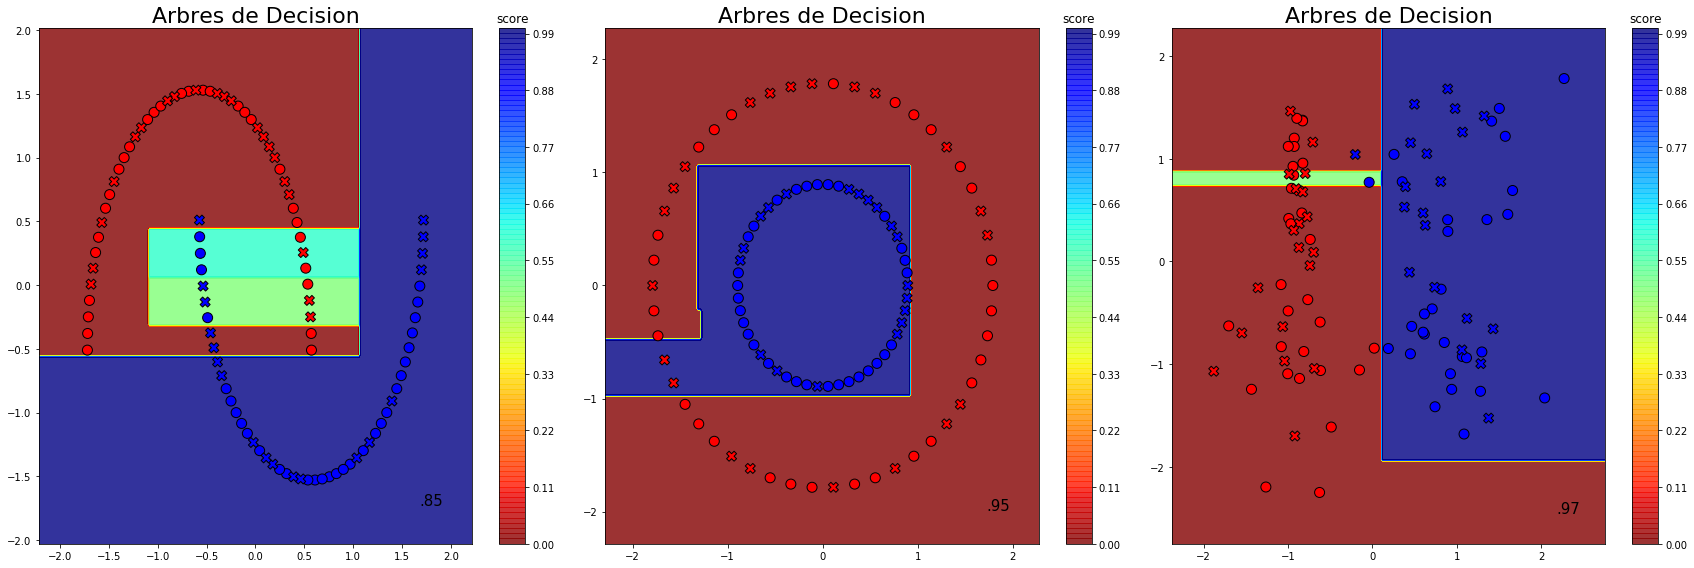

In [6]:
# Profondeur souhaitée de l'arbre de décision
profondeur = 6
# Règles sur une seule ou sur les deux caractéristiques à la fois
nombre_var = 1 # 1 ou 2 
# Nombre minimal d'exemple dans une feuille
min_par_feuille = 2

dec = DecisionTreeClassifier(max_depth=profondeur, max_features=nombre_var,min_samples_leaf=min_par_feuille, random_state=rng_seed)
plotClassifier("Arbres de Decision",  dec, datasets)

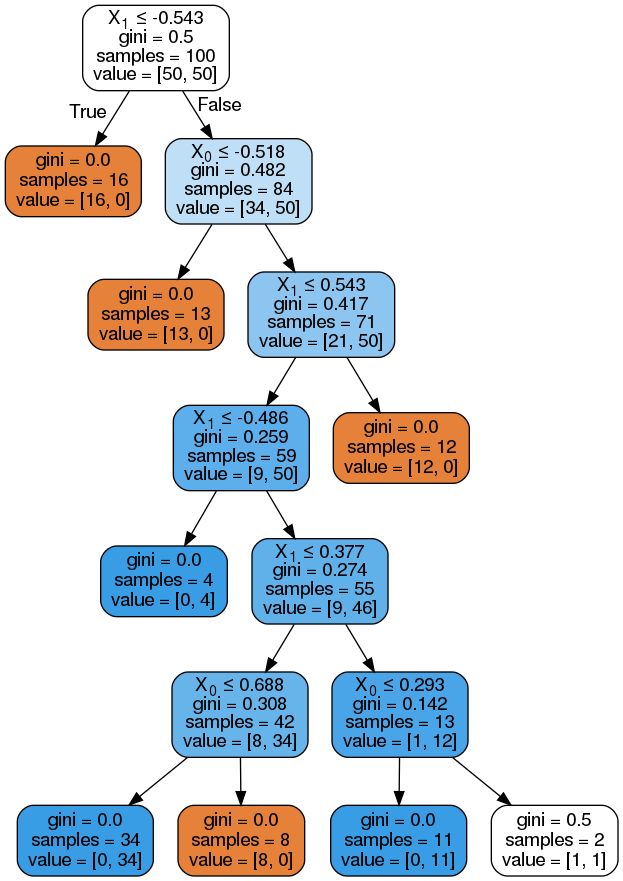

In [7]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
dec.fit(*datasets[1]) # datasets : 0 : Moons | 1 : Cercles | 2 : Lineairement Séparable

export_graphviz(dec, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

<div id="rf"/>
## 3. Forêt Aléatoire (Random Forest)

Une forêt aléatoire est un ensemble d'arbres de décision qui peuvent éventuellement sur-apprendre chacun différemment (Bagging). 

[`sklearn.ensemble.RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Voici les paramètres auxquels nous devons faire attention lorsque nous construisons une forêt :
- `n_estimators` : le nombre d'arbres dans la forêt;
- `max_features` : le nombre de caractéristiques à considérer lors de la recherche du meilleur partage;
- `min_samples_leaf` : nombre minimal d'échantillons requis pour être au niveau d'un nœud feuille;
- `max_depth` : la profondeur maximale de l'arbre;
- `criterion` : la fonction utilisée pour mesurer la qualité d'une scission.


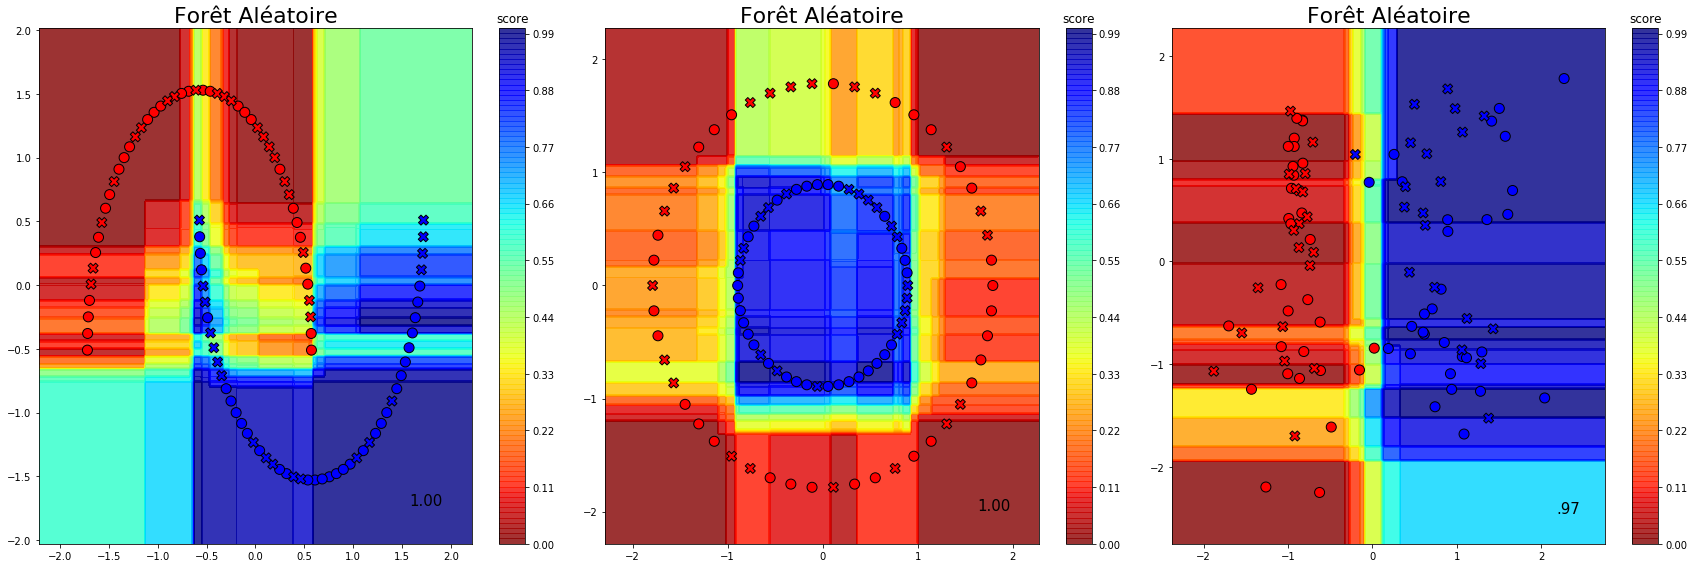

In [8]:
# Profondeur souhaitée de l'arbre de décision
profondeur = 5
# Nombres d'arbres dans la forêt
nombre_arbre = 15
# Règles sur une seule ou sur les deux caractéristiques à la fois
nombre_var = 1 # 1 ou 2 
# Critere de séparation : 'gini' ou 'entropy'
critere = 'gini'
# Nombre minimal d'exemple dans une feuille
min_par_feuille = 2

plotClassifier("Forêt Aléatoire",  RandomForestClassifier(max_depth=profondeur, n_estimators=nombre_arbre, max_features=nombre_var, criterion=critere,min_samples_leaf=min_par_feuille, random_state=rng_seed), datasets)



<div id="ada"/>
## 4. AdaBoost

Adaboost utilise également un ensemble d'arbres de décision mais qui sous-apprennent (ils ont une profondeur de 1 par défaut).

[`sklearn.ensemble.AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm=’SAMME.R’, random_state=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Voici les paramètres auxquels nous devons faire attention lorsque nous construisons un modèle Adaboost:
- `n_estimators` : le nombre d'arbres utilisés;
- `learning_rate` : le taux d'apprentissage, i.e. la variation sur le poids des exemples mal classés.

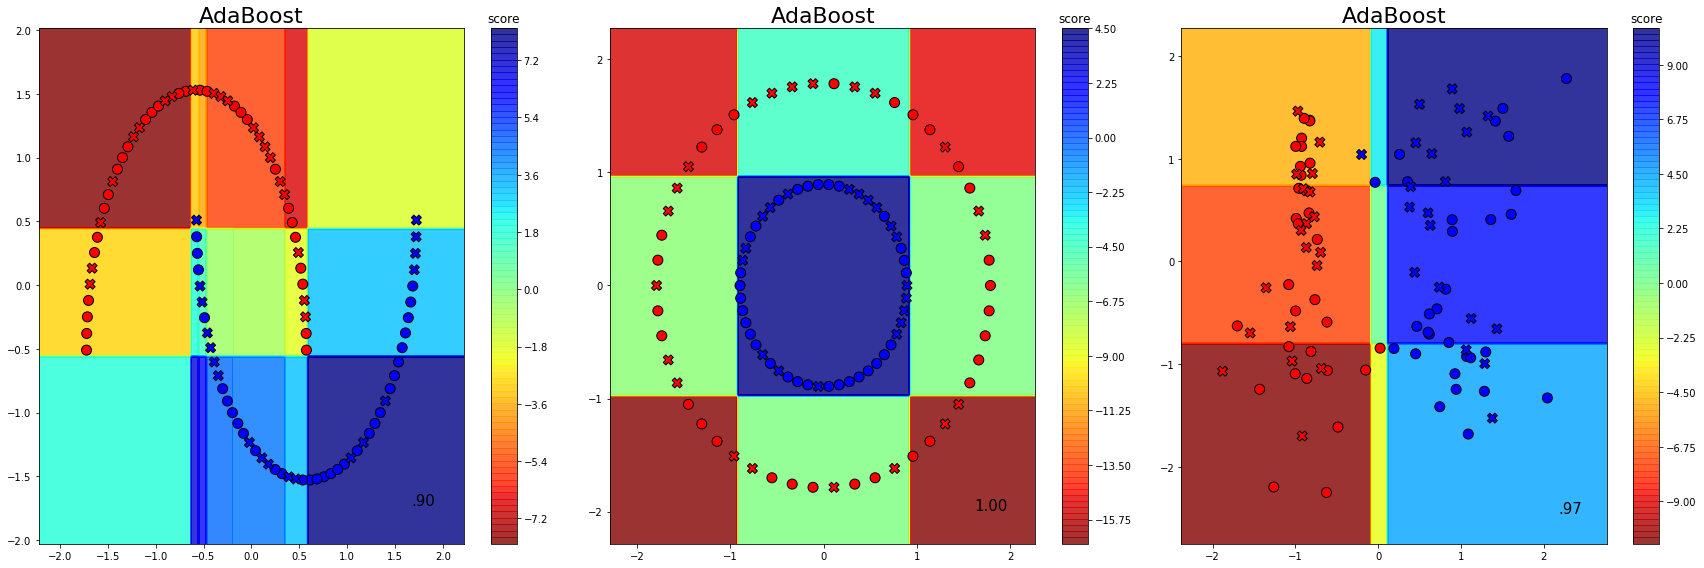

In [9]:
# Nombres d'arbres boosters
nombre_arbre = 15
# taux d'apprentissage 
alpha = 0.5

plotClassifier("AdaBoost", AdaBoostClassifier(n_estimators=nombre_arbre, learning_rate=alpha,random_state=rng_seed), datasets)

<div id="boost"/>
## 5. Gradient Boosting

Gradient Boosting est une version généralisée d'Adaboost. 

[`sklearn.ensemble.GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Les paramètres auxquels nous devons faire attention sont les mêmes que lorsque nous construisons un modèle Adaboost :
- `n_estimators` : le nombre d'arbres utilisés;
- `learning_rate` : le taux d'apprentissage, i.e. la variation sur le poids des exemples mal classés;

Auxquels ont peut ajouter 
- `subsample` : La fraction d'examples à utiliser pour ajuster les classificateurs (`bootstraping`). Si inférieur à 1.0, l'algorithme devient du [`Stochastic Gradient Boosting`](https://en.wikipedia.org/wiki/Gradient_boosting#Stochastic_gradient_boosting).



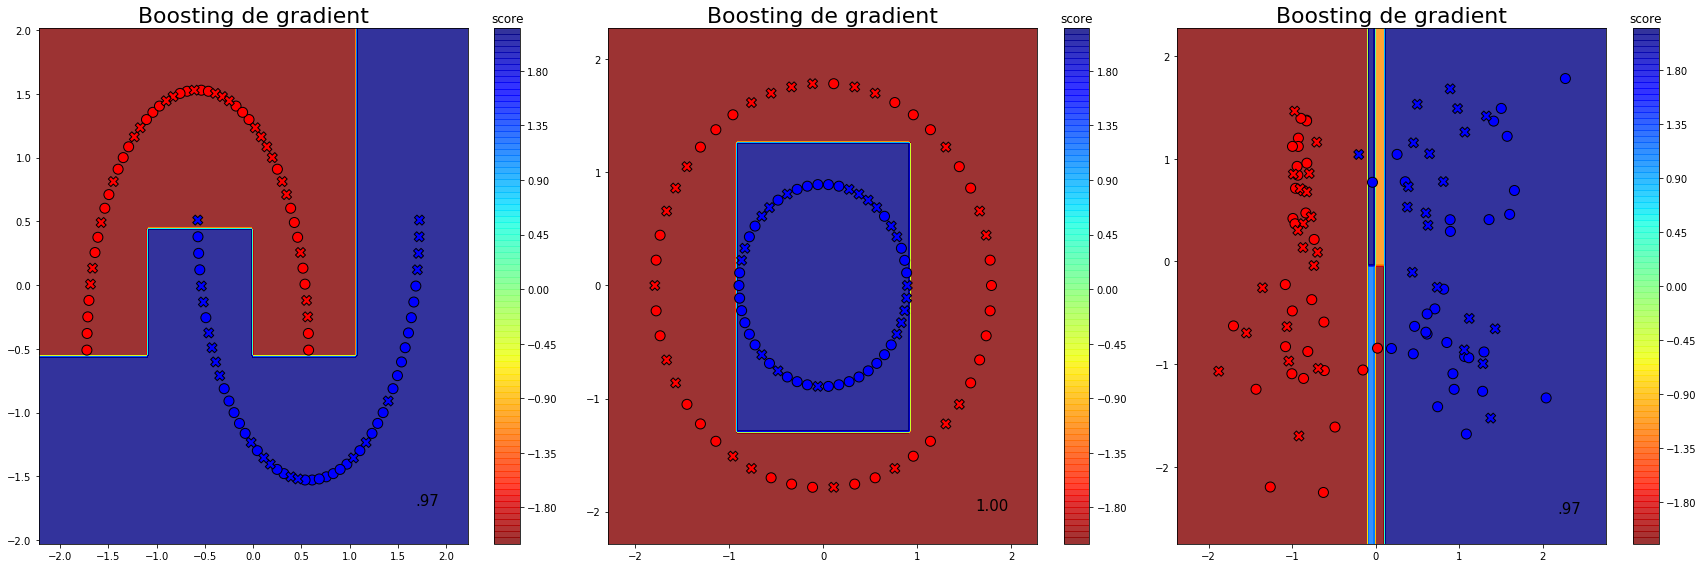

In [10]:
# Nombres d'arbres boosters
nombre_arbre = 15
# taux d'apprentissage 
alpha = 0.1
# Profondeur souhaitée de l'arbre de décision
profondeur = 5
# fraction des examples
fraction = 1.0

clf = GradientBoostingClassifier(n_estimators=nombre_arbre, learning_rate=alpha, subsample=fraction, max_depth=profondeur, random_state=rng_seed)

plotClassifier("Boosting de gradient",  clf, datasets)

<div id="rl"/>
## 6. Regression logistique

Ou comment faire de la régression linéaire avec des classes.

[`sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’warn’, max_iter=100, multi_class=’warn’, verbose=0, warm_start=False, n_jobs=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Les principaux paramètres de la régression logistique sont les suivants:
- `penalty` : La norme ($L_1$ ou $L_2$) utilisée pour calculer la fonction de perte;
- `max_iter` : nombre maximal d'itération ;
- `C` : Le paramètre inverse de régularisation dans $[0,1]$, plus `C` est proche de 0, plus la régularisation est forte.

On constate que dans le cas de ces datasets, la capacité simple du classificateur n'est pas suffisante, il faudrait faire une projection dans l'espace des caractéristiques pour augmenter sa capacité et ainsi améliorer l'exactitude.


/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


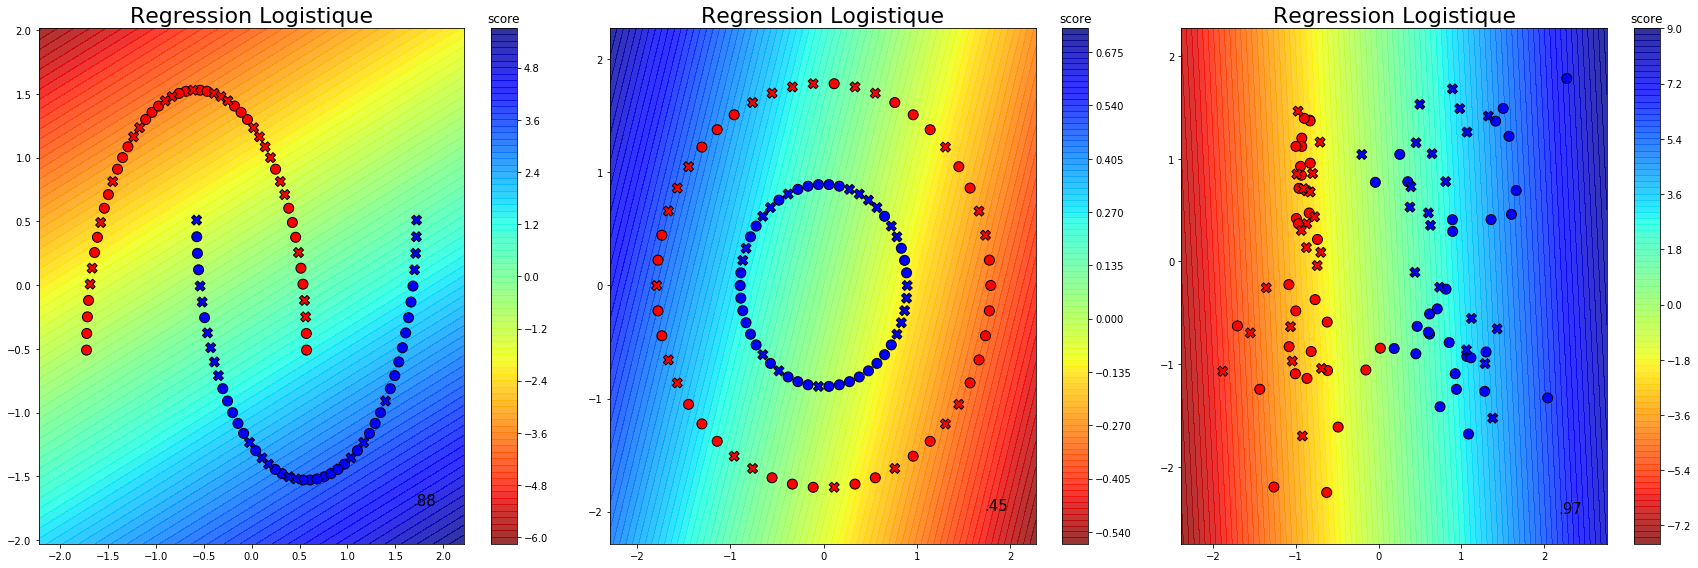

In [11]:
# pénalité = 'l1' ou 'l2'
pénalité = 'l2' # ou 'l1'
# Nombre d'itérations pour s'assurer de la convergence, si un warning apparait, c'est généralement à cause de ca.
iterations = 100
# Régularisation inverse [0,1]
ireg = 1.0

plotClassifier("Regression Logistique",LogisticRegression(random_state=rng_seed,max_iter=iterations,penalty=pénalité,C=ireg), datasets)

<div id="nn"/>
## 7. Perceptron Multi-Couches

[`sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’, learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Les principaux paramètres du perceptron sont les suivants:
- `hidden_layer_sizes` : Le nombre de neurones sur la (ou les) couche(s) cachée(s).
- `activation` : La fonction d'activation de chaque neurone.
- `alpha` : Taux de régularisation $L_2$ sur les poids.
- `max_iter`,`tol` : `max_iter` est le nombre d'itération avant d'arrêter si on ne souhaite pas attendre la convergence définie par la tolérance `tol` ( = 0.0001 par défaut).


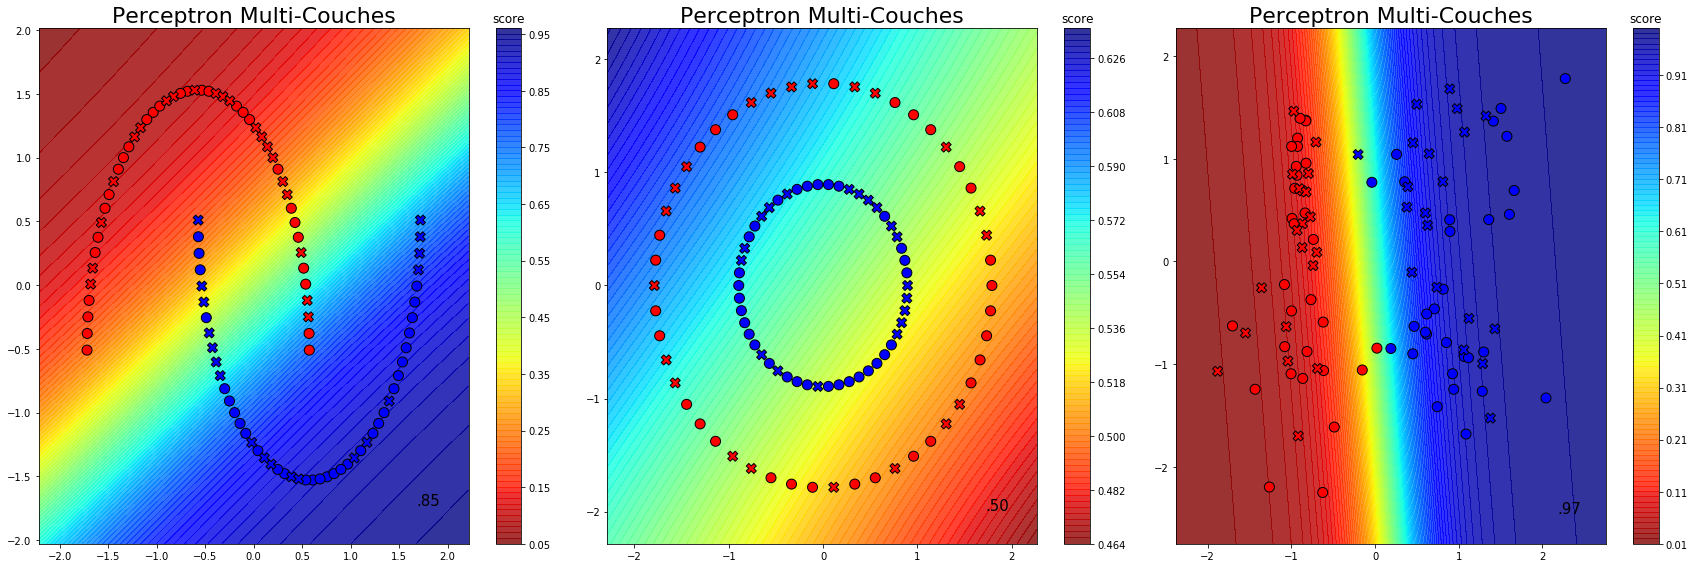

In [12]:
# Taux de régularisation (defaut à 0.0001)
regu = 0.01
# Nombre d'itérations pour s'assurer de la convergence, si un warning apparait, c'est généralement à cause de ca.
iterations = 2000

# Nombre de neurones sur la (ou les) couche(s) cachée(s), une valeur par couche. eg. (5,) : une seule couche cachée de 5 neurones. (5,3) : deux couches cachées une avec 5 l'autre avec 3.
taille = (5,)
# Fonction d'activation : ‘identity’, ‘logistic’, ‘tanh’, ‘relu’
activ = 'logistic'


clf = MLPClassifier(hidden_layer_sizes=taille, activation=activ, alpha=regu, max_iter=iterations, random_state=rng_seed)

plotClassifier("Perceptron Multi-Couches",  clf, datasets)

<div id="svm"/>
## 8. Support Vector Machines (SVM)

Ou machines à vecteur de support (avec noyau linéaire ou gaussien).

[`sklearn.svm.SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

Les principaux paramètres du SVM sont les suivants:
- `kernel` : le noyau à utiliser pour la mesure de distance;
- `C` : régularisation des points de support;
- `max_iter`,`tol` : `max_iter` est le nombre d'itération avant d'arrêter si on ne souhaite pas attendre la convergence définie par la tolérance `tol` ( = 0.001 par défaut).

/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


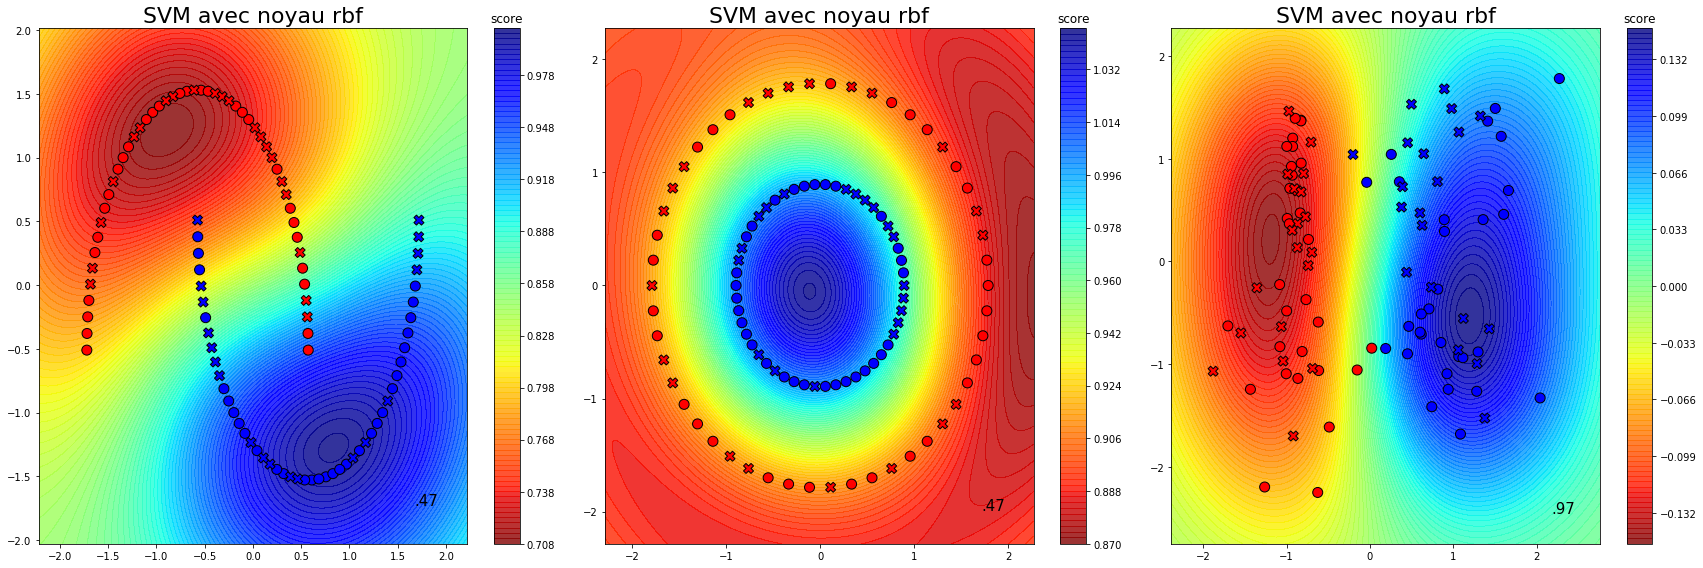

In [13]:
# Taux de régularisation (defaut à 0.0001)
regu= 0.01
# Noyau utilisé pour la transformation d'espace : 'linear', 'poly' (de degré 3 par défaut), 'rbf', 'sigmoid'
noyau = 'rbf'
# Nombre d'itérations pour s'assurer de la convergence, si un warning apparait, c'est généralement à cause de ca.
iterations = 2000

plotClassifier("SVM avec noyau "+noyau, SVC(kernel=noyau, C=regu, max_iter=iterations), datasets)


<div id="gp"/>
## 9. Processus Gaussien

[`sklearn.gaussian_process.GaussianProcessClassifier(kernel=None, optimizer=’fmin_l_bfgs_b’, n_restarts_optimizer=0, max_iter_predict=100, warm_start=False, copy_X_train=True, random_state=None, multi_class=’one_vs_rest’, n_jobs=None)`](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html)

Le principal paramètre du Processus Gaussien est le `kernel` i.e. le noyau à utiliser pour la mesure de distance. On pourra essayer les différents noyaux définis dans le code.
Il ne sera pas nécessaire d'optimiser les hyperparmaètres du noyau puisque l'apprentissage s'en occupe.

Voici la documentation des différents noyaux : 
- [Constant](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html#sklearn.gaussian_process.kernels.ConstantKernel)
- [Dot product](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.DotProduct.html#sklearn.gaussian_process.kernels.DotProduct)
- [RBF](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF)
- [Matern](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html#sklearn.gaussian_process.kernels.Matern) : RBF généralisé
- [Rational Quadratic](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html#sklearn.gaussian_process.kernels.RationalQuadratic) : mixture infinie de RBF


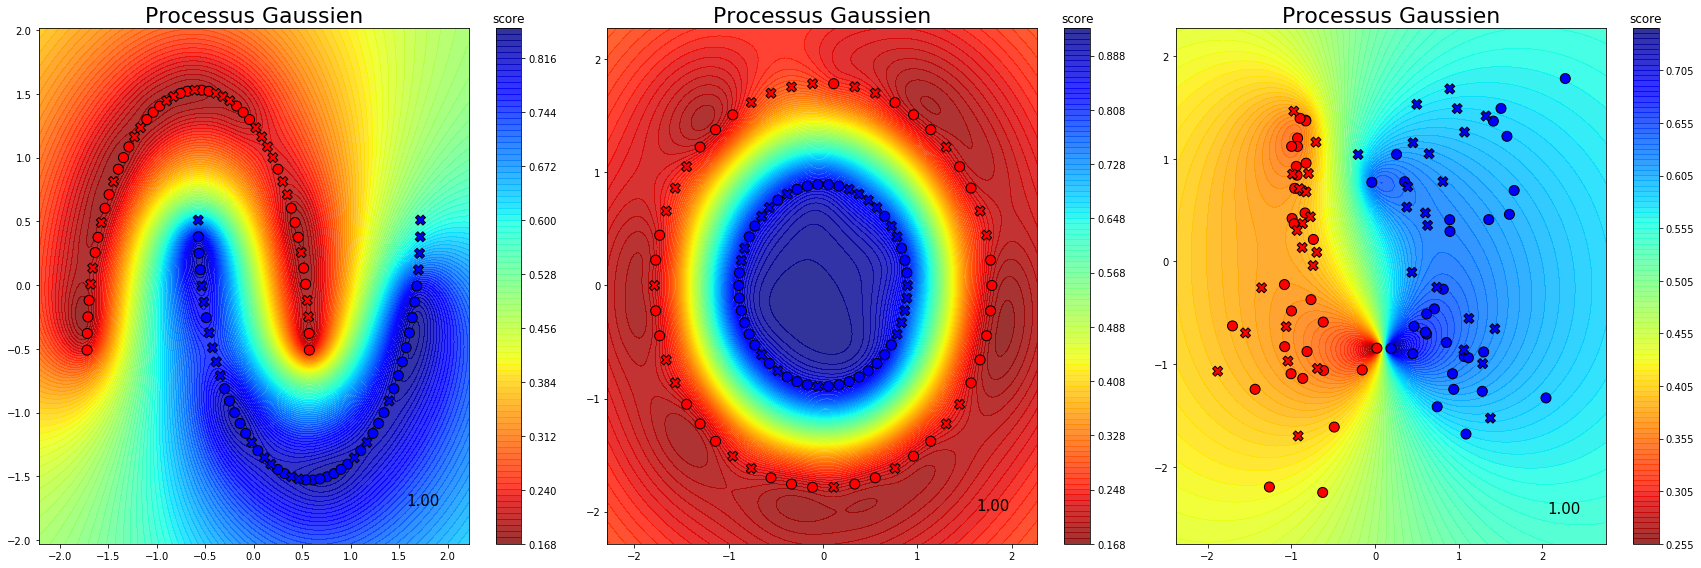

In [14]:
# noyauRBF_isotropique = 1.0 * RBF([1.0])
# noyauRBF_anisotropique = 1.0 * RBF([1.0, 1.0])

noyauRBF = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
noyauRQ = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
noyauDP = ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)
noyauM = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.0)

plotClassifier("Processus Gaussien",  GaussianProcessClassifier(kernel=noyauM), datasets)


---
## Algorithmes de Classification Multiclasses
---

On va changer de données : regardons les données de plusieurs types d'Iris (les fleurs):

<img src="https://cdn-images-1.medium.com/max/1600/1*2uGt_aWJoBjqF2qTzRc2JQ.jpeg" width="500"/>


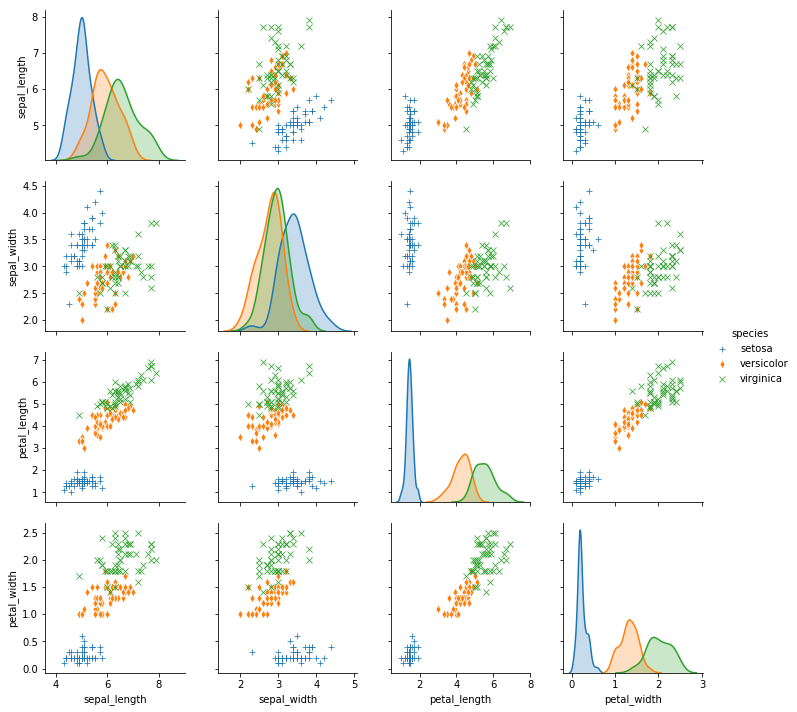

,sepal_length,sepal_width,petal_length,petal_width,species
101,5.8,2.7,5.1,1.9,virginica
36,5.5,3.5,1.3,0.2,setosa
24,4.8,3.4,1.9,0.2,setosa
94,5.6,2.7,4.2,1.3,versicolor
74,6.4,2.9,4.3,1.3,versicolor
67,5.8,2.7,4.1,1.0,versicolor
30,4.8,3.1,1.6,0.2,setosa
110,6.5,3.2,5.1,2.0,virginica
125,7.2,3.2,6.0,1.8,virginica
143,6.8,3.2,5.9,2.3,virginica


In [15]:
import pandas as pd
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder


from sklearn.model_selection import train_test_split

iris = sns.load_dataset("iris")

g = sns.pairplot(iris, hue='species', markers=['+','d','x'])
plt.show()
iris.sample(10)

### Rappel : Séparer les données en deux : entrainement et test
#### Avantages

   - En séparant les données aléatoirement on ne teste pas sur les mêmes données que celles entrainées
   - Cela garantit que nous n'utiliseront pas les mêmes observations dans les deux ensembles 
   - Cela généralise mieux les données plus rapidement

#### Disadvantages
   - Le score d'exactitude sur l'ensemble de test varie en fonction des données qui y ont été sélectionnées
   - On peut mitiger ca en utilisant la validation croisée

#### Notes
   - Le score d'exactitude  des modèles dépend des observations de l'ensemble de test, qui est déterminé par l'initilisation  du générateur pseudo-aléatoire.
   - Plus la complexité du modèle augmente, plus l'exactitude d'entrainement augmente
   - Si un modèle est trop complexe (overfitting) ou pas assez complexe (underfitting), l'exactitude d'entrainement est trop basse. 


In [16]:
X = iris.drop('species', axis=1)
y = iris['species']

# print(X.head())
# print(X.shape)
# print(y.head())
# print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rng_seed)

Une fois séparés on peut valider quelle serait la meilleure valeur de $k$ dans un $k$-NN sur l'ensemble des données d'entrainement.

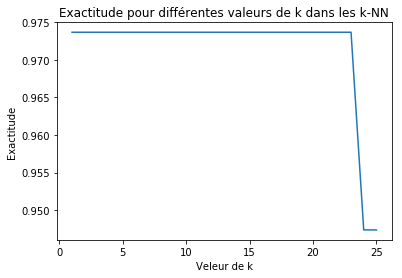

In [17]:
# experimentons avec différentes valeurs de k
k_range = list(range(1,26))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
    
plt.plot(k_range, scores)
plt.xlabel('Veleur de k')
plt.ylabel('Exactitude')
plt.title('Exactitude pour différentes valeurs de k dans les k-NN')
plt.show()

/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


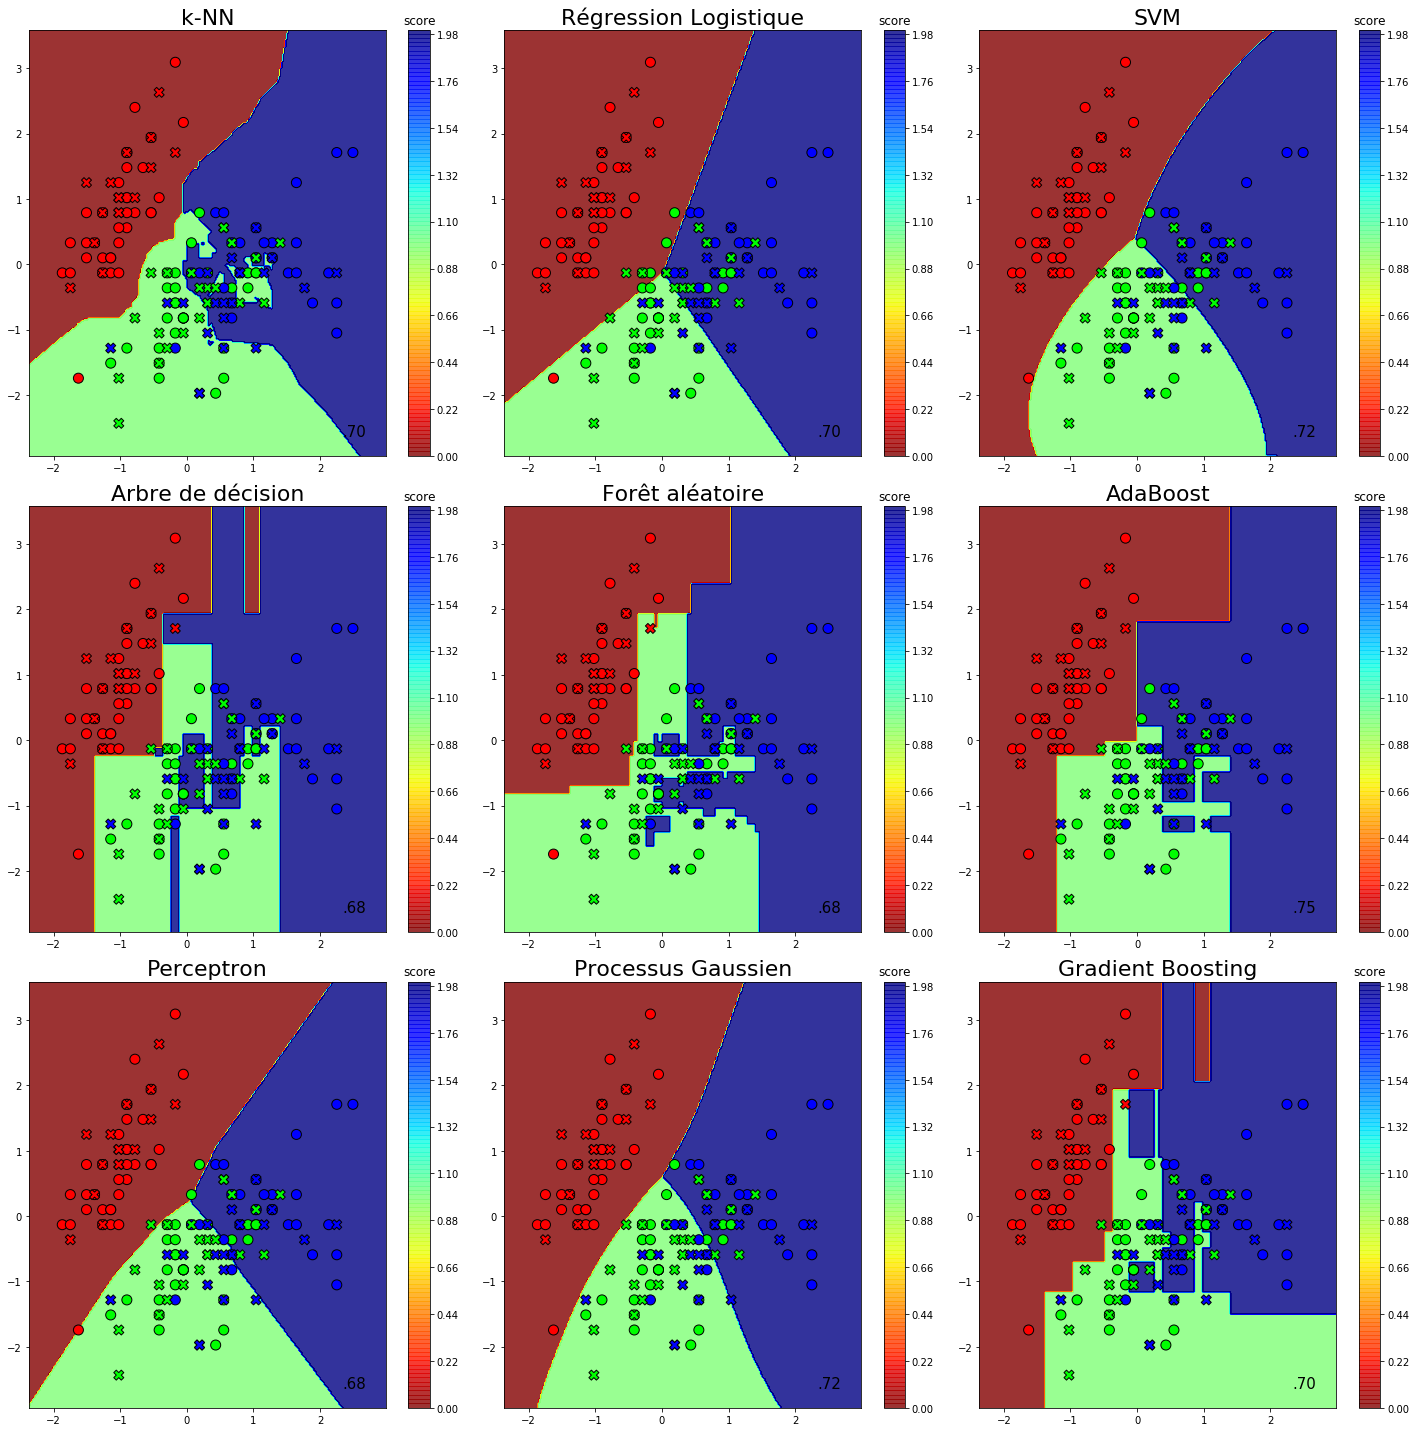

In [18]:

#Choisir les caractéristiques en entrée: 
c0 = 'sepal_length'
c1 = 'sepal_width'
c2 = 'petal_length'
c3 = 'petal_width'

f1 = c0
f2 = c1
#  ----------------------

# Paramétrer les classificateurs
clfs = [
    KNeighborsClassifier(n_neighbors=3, weights='uniform', leaf_size=30),
    LogisticRegression(random_state=rng_seed,max_iter=1000,penalty='l2',C=0.01),
    SVC(kernel='rbf', C=1,gamma=.2,max_iter=1000),
    DecisionTreeClassifier(max_depth=6, random_state=rng_seed),
    RandomForestClassifier(max_depth=6, n_estimators=15, max_features=2, random_state=rng_seed),
    AdaBoostClassifier(n_estimators=15, learning_rate=0.5,random_state=rng_seed),
    MLPClassifier(hidden_layer_sizes=(5,), activation='relu', alpha=0.01, max_iter=1000, random_state=rng_seed),
    GaussianProcessClassifier(kernel=noyauRBF),
    GradientBoostingClassifier(n_estimators=15, learning_rate=0.5, subsample=1, max_depth=2, random_state=rng_seed),
]
# Liste des noms associés
clf_names = [
    'k-NN','Régression Logistique','SVM',
    'Arbre de décision','Forêt aléatoire','AdaBoost',
    'Perceptron','Processus Gaussien','Gradient Boosting'   
]

#  ----------------------

# Création du dataset 
X = iris[[f1,f2]].values

## Encodage des espèces en valeurs numériques pour la coloration
le = LabelEncoder()
le.fit(iris.species.unique())
y = le.transform(iris.species)
data_iris = [X,y]
#  ----------------------

# Affichage des frontières de décision pour nos neuf classificateurs 
f = plt.figure(figsize= (20,20))

# Pour chacun des Classificateurs
for cnt, clf in enumerate(clfs):
    plotClassifierOnData(clf_names[cnt], OneVsRestClassifier(clf), data_iris,cnt+1,len(clfs),True)


plt.tight_layout()
plt.show()

Voyons les matrices de confusion pour ces classificateurs : 

/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/formation/.venv/formation-ai/lib/python3.6

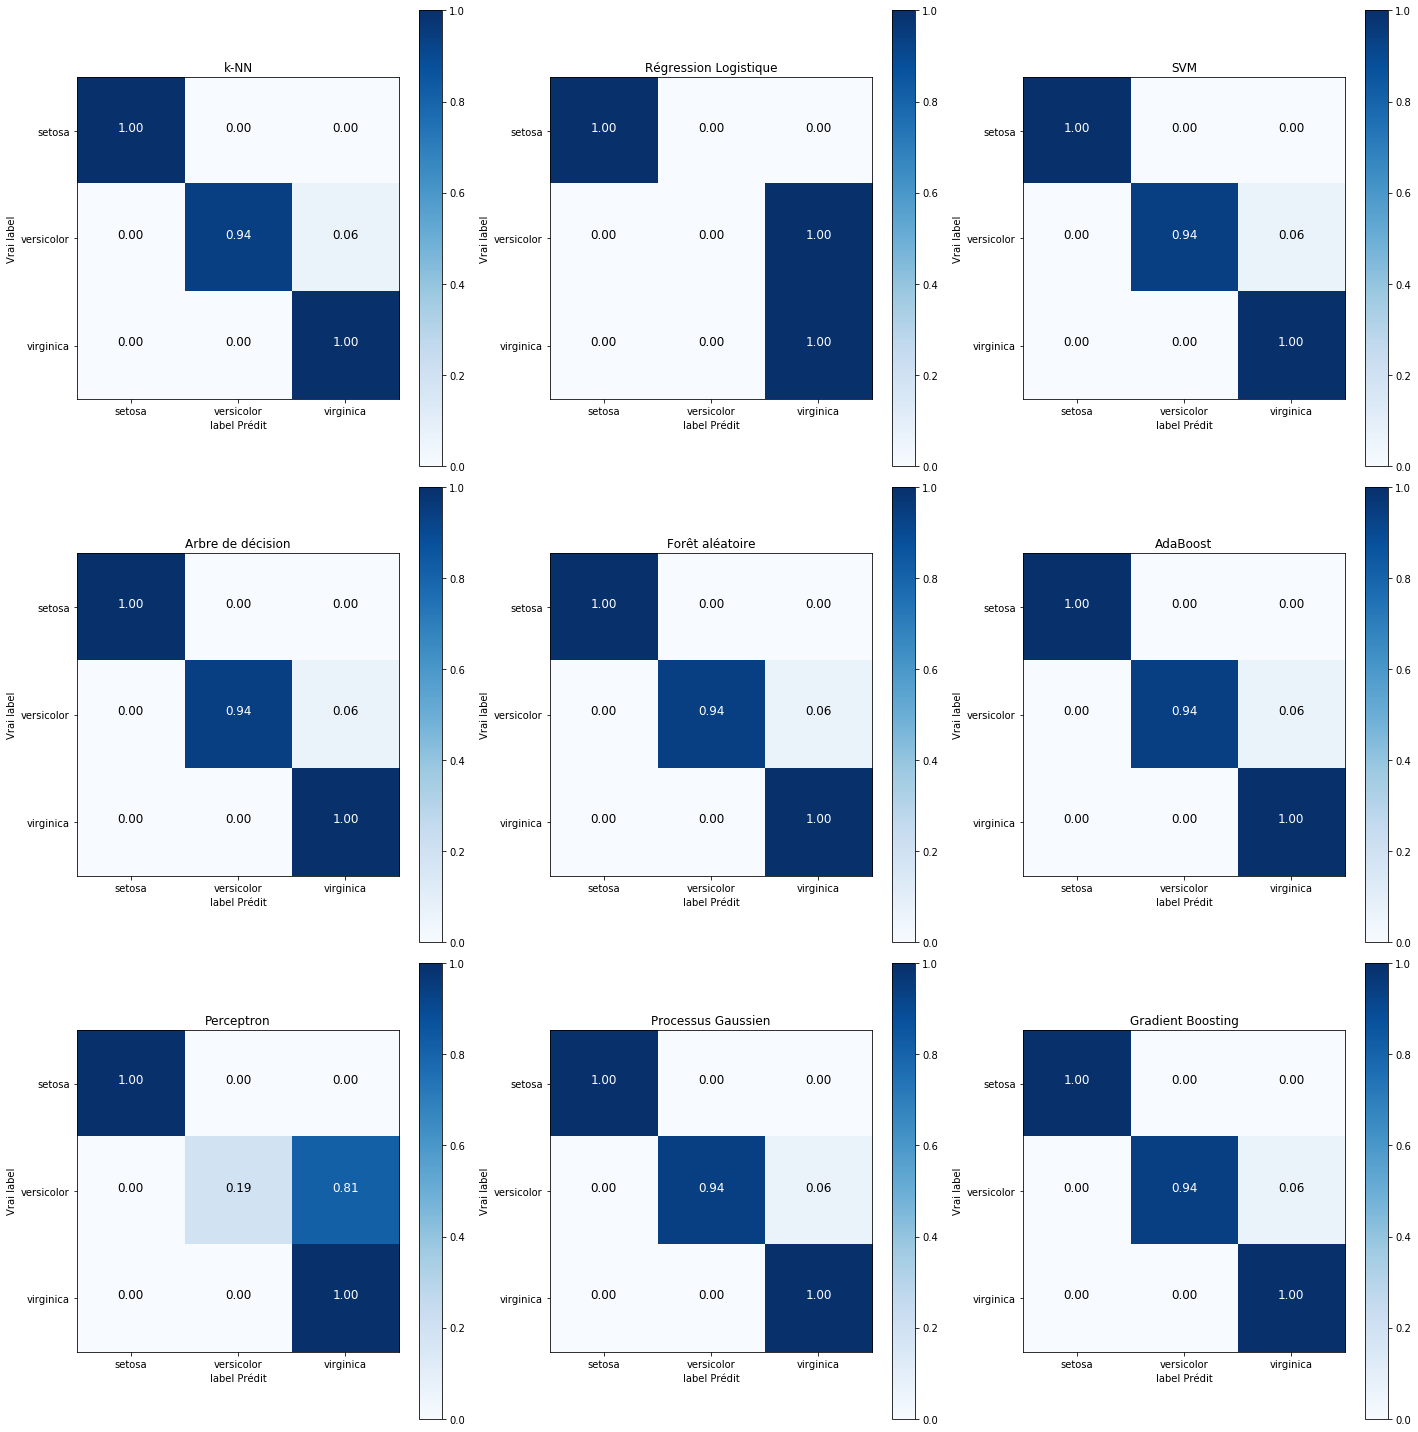

In [19]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(clf,classes,                       
                          title,i,n,X_train,y_train,
                          cmap=plt.cm.Blues):
    """
    Cette fonction calcule et affiche la matrice de confusion pour un classificateur donné.
    clf : classificateur
    classes : les classes à déterminer dans le dataset
    title : 
    """
    y_pred = clf.fit(X_train, y_train).predict(X_test)

    # Calcul de la matrice de confusion
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    cnf_matrix  = cnf_matrix .astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

    ax = plt.subplot(n/3,3,i)
    test = ax.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    cbar = plt.colorbar(test)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black",size=12)

    ax.set_ylabel('Vrai label')
    ax.set_xlabel('label Prédit')

# Affichage des matrices de confusion pour nos neuf classificateurs 
f = plt.figure(figsize= (20,20))

# Pour chacun des Classificateurs
for cnt, clf in enumerate(clfs):
    plot_confusion_matrix(OneVsRestClassifier(clf), iris.species.unique(), clf_names[cnt],cnt+1,len(clfs),X_train,y_train)

plt.tight_layout()
plt.show()

___
# A vous de jouer ! 
___

Dans cet exercice vous avez les moyens de maintenant choisir le bon classificateur et ses hyperparamètres en utilisant toutes les connaissances de la journée.

Nous allons charger un dataset contenant 4 types de fruits (Pommes, Oranges, Mandarines et Citrons) et c'est à vous de déterminer à partir de leur masse, hauteur, largeur, couleur, quels sont les types de fruits.

Un exemple de code vous est donné pour pouvoir visualiser les données, mais rappelez vous qu'il est plus intéressant d'utiliser l'ensemble des données plutot que juste deux colonnes de celles-ci !


In [20]:
# On élimine la colonne "subtype" qui pourra faire l'objet d'exercieces supplémntaires
fruits = pd.read_table('fruits.txt').drop('fruit_subtype',axis=1)

/home/formation/.venv/formation-ai/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


Jetons un oeuil aux données:

In [21]:
fruits.sample(10)

,fruit_label,fruit_name,mass,width,height,color_score
32,3,orange,164,7.2,7.0,0.80
12,1,apple,154,7.0,7.1,0.88
29,3,orange,160,7.0,7.4,0.81
30,3,orange,158,7.1,7.5,0.79
16,1,apple,156,7.6,7.5,0.67
14,1,apple,152,7.6,7.3,0.69
38,3,orange,158,7.2,7.8,0.77
5,2,mandarin,80,5.8,4.3,0.77
44,4,lemon,200,7.3,10.5,0.72
3,2,mandarin,86,6.2,4.7,0.80


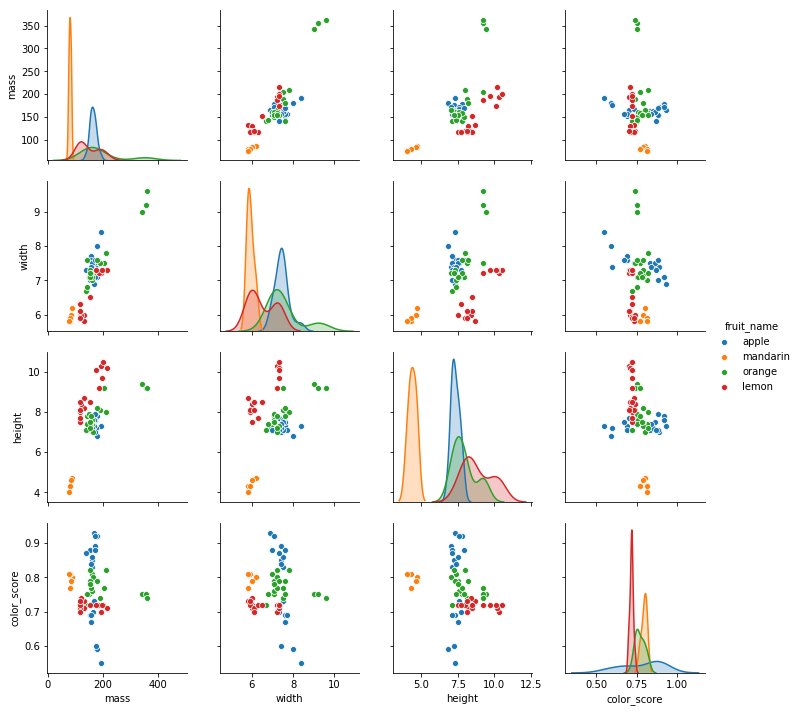

In [22]:
g = sns.pairplot(fruits.drop('fruit_label',axis=1), hue='fruit_name')
plt.show()

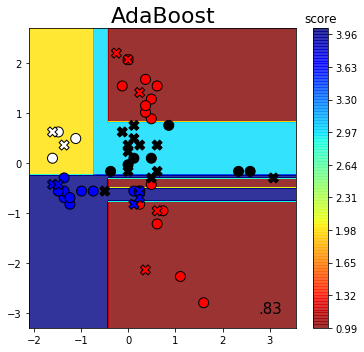

In [23]:
#Choisir les caractéristiques en entrée: 
c0 = 'mass'
c1 = 'width'
c2 = 'height'
c3 = 'color_score'

#  ----------------------

# Création du dataset 
X = fruits[[c1,c3]].values
y = fruits['fruit_label']
data = [X,y]
#  ----------------------

# Choix du classificateur

choix = 5

# Choix des hyper-paramètres (grid search ? cross-validation ?)
clfs = [
    KNeighborsClassifier(n_neighbors=3, weights='uniform', leaf_size=30),
    LogisticRegression(random_state=rng_seed,max_iter=1000,penalty='l2',C=0.01),
    SVC(kernel='rbf', C=1,gamma=.2,max_iter=1000),
    DecisionTreeClassifier(max_depth=6, random_state=rng_seed),
    RandomForestClassifier(max_depth=6, n_estimators=15, max_features=2, random_state=rng_seed),
    AdaBoostClassifier(n_estimators=100, learning_rate=0.3,random_state=rng_seed),
    MLPClassifier(hidden_layer_sizes=(5,), activation='relu', alpha=0.01, max_iter=1000, random_state=rng_seed),
    GaussianProcessClassifier(kernel=noyauRBF),
    GradientBoostingClassifier(n_estimators=15, learning_rate=0.5, subsample=1, max_depth=2, random_state=rng_seed),
]

clf_names = [
    'k-NN','Régression Logistique','SVM',
    'Arbre de décision','Forêt aléatoire','AdaBoost',
    'Perceptron','Processus Gaussien','Gradient Boosting'   
]


# Affichage des frontières de décision pour le classificateur choisi (OvO ? OvR ?)
f = plt.figure(figsize= (15,5))
plotClassifierOnData(clf_names[choix], OneVsOneClassifier(clfs[choix]), data,1,3,True)
plt.tight_layout()
plt.show()

In [24]:
X = fruits[[c0,c1,c2,c3]]
y = fruits['fruit_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=rng_seed)

nb_est = 500
alpha = 0.3

clfs = [
    KNeighborsClassifier(n_neighbors=12, weights='distance', leaf_size=5),
    LogisticRegression(random_state=rng_seed,max_iter=2000,penalty='l2',C=3),
    SVC(kernel='rbf', C=0.001,gamma=.01,max_iter=1000),
    DecisionTreeClassifier(max_depth=226, random_state=rng_seed),
    RandomForestClassifier(max_depth=226, n_estimators=250, max_features=3, random_state=rng_seed),
    AdaBoostClassifier(n_estimators=500, learning_rate=0.3,random_state=rng_seed),
    MLPClassifier(hidden_layer_sizes=(10,), activation='relu', alpha=0.001, max_iter=5000, random_state=rng_seed),
    GaussianProcessClassifier(kernel=noyauM),
    GradientBoostingClassifier(n_estimators=1500, learning_rate=0.9, subsample=1, max_depth=2, random_state=rng_seed),
]


for cnt, clf0 in enumerate(clfs):
    clf = OneVsRestClassifier(clf0)
    # entrainement du classificateur et calcul du score final (accuracy)
    clf.fit(X_train, y_train)
    print("%25s - [s:%.3f]" % (clf_names[cnt], clf.score(X_test, y_test)))

                     k-NN - [s:0.625]
    Régression Logistique - [s:0.542]
                      SVM - [s:0.500]
        Arbre de décision - [s:0.667]


/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/formation/.venv/formation-ai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


          Forêt aléatoire - [s:0.750]
                 AdaBoost - [s:0.958]
               Perceptron - [s:0.083]
       Processus Gaussien - [s:0.500]
        Gradient Boosting - [s:0.875]
